In [173]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Optional: Adjust column width for better visibility
pd.set_option('display.max_colwidth', None)

# 0) Loading data
We save the target variable as `y` and then concatenate the train and test sets to run the data preprocessing steps on them simultaneously.

In [189]:
df_test = pd.read_csv('test.csv', index_col='Id')
df_train = pd.read_csv('train.csv', index_col='Id')
y = df_train['SalePrice']
index_train = df_train.index
index_test = df_test.index
df_train = df_train.drop('SalePrice', axis=1)
df = pd.concat([df_train, df_test])


During data exploration I identified the types of each column.

In [186]:
nominal_columns = ['MSSubClass', 'MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
       'CentralAir', 'Electrical', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_columns = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual',
 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
 'Fence', 'PavedDrive', 'Alley']

numerical_columns = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


#1) Data preprocessing

## 1.1) Handling missing values

In [192]:
df_missing_ratio = 100 * df.isna().sum() / len(df)
df_missing_ratio[df_missing_ratio > 0]


,0
MSZoning,0.137033
LotFrontage,16.649538
Utilities,0.068517
Exterior1st,0.034258
Exterior2nd,0.034258
MasVnrArea,0.787941
BsmtFinSF1,0.034258
BsmtFinSF2,0.034258
BsmtUnfSF,0.034258
TotalBsmtSF,0.034258


Some of them should be filled with the string `NA` after checking the data description.

In [191]:
columns_to_fill_na = ['Alley', 'MasVnrType', 'MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in columns_to_fill_na:
  df[col] = df[col].fillna('NA')


The columns should be imputed with 0 values.

In [194]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)


Delete columns, where at least a lot of the entries are missing.

In [195]:
df_missing_ratio = 100 * df.isna().sum() / len(df)
df_missing_ratio[df_missing_ratio > 0]

ratio_high_missing = 20

columns_high_missing = df_missing_ratio[df_missing_ratio > ratio_high_missing].index
df.drop(columns=columns_high_missing, inplace=True)

numerical_columns = [col for col in numerical_columns if col in df.columns]
ordinal_columns = [col for col in ordinal_columns if col in df.columns]
nominal_columns = [col for col in nominal_columns if col in df.columns]


Check and impute the other columns with missing values.


In [196]:
df_missing_ratio = df.isna().sum() / len(df)
columns_low_missing = df_missing_ratio[df_missing_ratio > 0].index
columns_low_missing


Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
       'GarageCars', 'GarageArea', 'SaleType'],
      dtype='object')

In [197]:
k = 5

# Step 1: KNN imputation for numerical columns (using KNNImputer)
knn_imputer = KNNImputer(n_neighbors=k)  # Choose k=5 for nearest neighbors

# Impute missing numerical columns
df_numerical = df[numerical_columns]
df_imputed_numerical = knn_imputer.fit_transform(df_numerical)
df_imputed_numerical = pd.DataFrame(df_imputed_numerical, columns=numerical_columns)


# Step 2: Combine the imputed numerical values back into the DataFrame
df[numerical_columns] = df_imputed_numerical

# Step 3: Compute Nearest Neighbors based on only numerical columns
# We will use NearestNeighbors to find nearest neighbors based on the numerical columns
# Fit the nearest neighbors model on the numerical columns
nn = NearestNeighbors(n_neighbors=k)  # k=5 for nearest neighbors
nn.fit(df_imputed_numerical)

# Step 4: Impute Ordinal and Nominal Columns based on the Mode of the Nearest Neighbors
def impute_categorical_with_knn(df, columns, nn, numerical_columns, k=5):
    for col in columns:
        for idx in df[df[col].isna()].index:
            # Find the nearest neighbors for the row with the missing value
            query_row = pd.DataFrame([df.loc[idx, numerical_columns].values], columns=numerical_columns)
            distances, indices = nn.kneighbors(query_row)

            # Get the values of the nearest neighbors for the categorical column
            neighbor_values = df.iloc[indices[0], df.columns.get_loc(col)]

            # Impute the mode (most frequent value) for categorical columns
            most_frequent_value = neighbor_values.mode()[0]
            df.at[idx, col] = most_frequent_value

    return df

# Impute missing ordinal and nominal columns with mode of nearest neighbors
df_imputed_categorical = impute_categorical_with_knn(df, ordinal_columns + nominal_columns, nn, numerical_columns)


Deleting rows with remaining missing values.

In [208]:
df = df_imputed_categorical[df_imputed_categorical.isna().sum(axis=1) == 0].copy()


## 1.2) Fix typos/inconsistencies

During data exploration no such thing was found.

## 1.3) Remove duplicates

In [199]:
df.drop_duplicates(inplace=True)

## 1.4) Converting categorical features

In [209]:
ordinal_columns_mapping = {
    'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
    'LandContour': {'Lvl': 1, 'Bnk': 2, 'HLS': 3, 'Low': 4},
    'Utilities': {'AllPub': 1, 'NoSewr': 2, 'NoSeWa': 3, 'ELO': 4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageType': {'2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3, 'CarPort': 2, 'Detchd': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
    'Alley': {'Pave': 2, 'Grvl': 1, 'NA': 0}
}


# Step 1: Replace the categorical values in the relevant columns using the
with pd.option_context('future.no_silent_downcasting', True):
  for col, col_mapping in ordinal_columns_mapping.items():
      if col in df.columns:
          df[col] = df[col].replace(col_mapping)

# Step 2: Create dummy variables for the nominal columns with prefixes and n-1 columns (excluding one)
df_dummies = pd.get_dummies(df[nominal_columns], drop_first=True)

# Step 3: Concatenate the original DataFrame (with non-nominal columns) and the dummy variables
df = pd.concat([df.drop(columns=nominal_columns), df_dummies], axis=1)


## 1.5) Dropping outliers

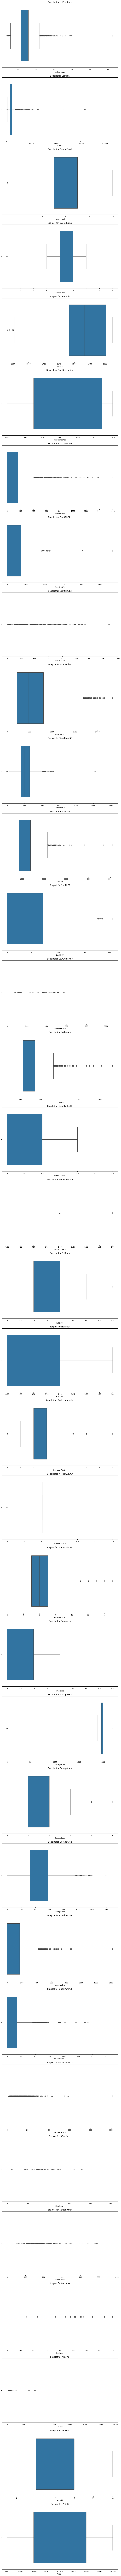

In [210]:
# Determine the number of numerical columns
num_columns = len(numerical_columns)

# Set the plot size (wider height to stack vertically)
plt.figure(figsize=(10, 6 * num_columns))

# Create a boxplot for each numerical column
for idx, col in enumerate(numerical_columns):
    plt.subplot(num_columns, 1, idx + 1)  # Create a subplot in a single column, multiple rows
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

In [213]:
# Define outlier thresholds
outlier_thresholds = {
    'LotFrontage': 300,
    'LotArea': 200000,
    'BsmtFinSF1': 3000,
    'TotalBsmtSF': 4000,
    'LowQualFinSF': 1000,
    'GrLivArea': 4000,
    'GarageYrBlt': 2050,
    'WoodDeckSF': 1000,
    'OpenPorchSF': 700,
    'EnclosedPorch': 800
}

# Function to remove outliers based on the thresholds and print how many rows were dropped
def remove_outliers(df, thresholds):
    for col, threshold in thresholds.items():
        # Find the outliers
        outliers = df[df[col] > threshold]

        # Count how many rows are outliers
        num_outliers = len(outliers)

        if num_outliers > 0:
            # Drop outliers
            df = df[df[col] <= threshold]
            print(f"Dropped {num_outliers} rows from {col} where values were above {threshold}.")

    return df

# Apply the function to remove outliers
df_cleaned = remove_outliers(df, outlier_thresholds)


Dropped 2 rows from LotFrontage where values were above 300.
Dropped 1 rows from LotArea where values were above 200000.
Dropped 1 rows from BsmtFinSF1 where values were above 3000.
Dropped 1 rows from LowQualFinSF where values were above 1000.
Dropped 3 rows from GrLivArea where values were above 4000.
Dropped 1 rows from GarageYrBlt where values were above 2050.
Dropped 1 rows from WoodDeckSF where values were above 1000.
Dropped 1 rows from OpenPorchSF where values were above 700.
Dropped 1 rows from EnclosedPorch where values were above 800.


## 1.6) Manually adding new features

In [214]:
# First, define initial features that don't depend on others in the dictionary
initial_features = {
    'Age': df['YrSold'] - df['YearBuilt'],
    'RemodelAge': df['YrSold'] - df['YearRemodAdd'],
    'Total_Baths': df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5 + df['FullBath'] + df['HalfBath'],
    'Total_Finished_SF': df['GrLivArea'] + df['TotalBsmtSF'],
    'Total_Porch_Area': df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'],
    'Garage_Age': df['YrSold'] - df['GarageYrBlt'],
    'Quality_Index': df['OverallQual'] + df['OverallCond'],
    'Total_Rooms': df['BedroomAbvGr'] + df['KitchenAbvGr'] + df['TotRmsAbvGrd']
}

# Add the initial features to the DataFrame
df = pd.concat([df, pd.DataFrame(initial_features, index=df.index)], axis=1)

# Now define additional features that depend on the initial features
additional_features = {
    'Lot_Size_per_Room': df['LotArea'] / (df['Total_Rooms']).replace(0, 1),
    'Living_Area_per_Bath': df['GrLivArea'] / df['Total_Baths'].replace(0, 1),
    'Garage_Area_Ratio': df['GarageArea'] / df['Total_Finished_SF'].replace(0, 1),
    'Total_Porch_per_Room': df['Total_Porch_Area'] / df['Total_Rooms'].replace(0, 1),
    'Quality_Adjusted_Area': df['TotalBsmtSF'] * df['Quality_Index']
}

# Add the additional features to the DataFrame
df = pd.concat([df, pd.DataFrame(additional_features, index=df.index)], axis=1)

# Drop unnecessary columns
columns_to_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
df = df.drop(columns=columns_to_drop, errors='ignore')


## 1.7) Scaling

## 1.8) Log-transformation

## 1.9) Feature selection